In [14]:
import uproot # for .root files
import time # to measure time to analyse
import math
import awkward as ak # for complex nested data structures
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for signal and background fits
import vector
import requests
import aiohttp
import atlasopenmagic as atom # to access data

<b> Accessing the data directly from ATLAS Open Data </b>

In [15]:
# atom.available_releases()
# https://opendata.cern.ch/record/93910
atom.set_release('2025e-13tev-beta') #latest release 

Active release set to: 2025e-13tev-beta. Metadata cache cleared.


<b> Within the data, n-tuples have already been selected (skimmed) to contain at least 2 photons under the name GamGam. </b>

In [16]:
skim = "GamGam"

In [17]:
# Get the files locally instead of streaming 
local_files = True

<b> The data is currently organized into collection periods. In this project 2015 data from periods D, E, F, G, H, J is used, as well as 2016 data from periods A, B, C, D, E, F, G, K, L. </b>

In [18]:
samples_list = atom.build_data_dataset(skim, protocol='https')

Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.


In [19]:
# We shall use the first entry in 'list', 'data15_periodD'
value = samples_list['Data']['list'][0]
print(f"{value = }")

# This is now appended to our file path to retrieve the data_A.4lep.root file
data15_periodD = value #path + "Data/" + value + ".root"

value = 'https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodD.GamGam.root'


In [20]:
# Accessing the file from the online database (":analysis" opens the tree in a desired manner)
if local_files:
    # Download the file, use a local copy
    local_filename = data15_periodD.split("/")[-1]
    print(f"Downloading {data15_periodD} to {local_filename} ...")
    with requests.get(data15_periodD, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    tree = uproot.open(local_filename + ":analysis")
else: # Stream files
    tree = uproot.open(data15_periodD + ":analysis")
# The number of entries in the tree can be viewed
print("The number of entries in the tree are:", tree.num_entries)

# All the information stored in the tree can be viewed using the .keys() method.
print("The information stored in the tree is:", tree.keys())

The number of entries in the tree are: 63195
The information stored in the tree is: ['num_events', 'sum_of_weights', 'sum_of_weights_squared', 'category', 'sig_ph', 'n_sig_ph', 'TriggerMatch_DILEPTON', 'ScaleFactor_MLTRIGGER', 'ScaleFactor_PILEUP', 'ScaleFactor_FTAG', 'mcWeight', 'xsec', 'filteff', 'kfac', 'channelNumber', 'eventNumber', 'runNumber', 'trigML', 'trigP', 'trigDT', 'trigT', 'trigE', 'trigDM', 'trigDE', 'trigM', 'trigMET', 'ScaleFactor_BTAG', 'ScaleFactor_JVT', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_btag_quantile', 'jet_jvt', 'largeRJet_n', 'largeRJet_pt', 'largeRJet_eta', 'largeRJet_phi', 'largeRJet_e', 'largeRJet_m', 'largeRJet_D2', 'jet_pt_jer1', 'jet_pt_jer2', 'ScaleFactor_ELE', 'ScaleFactor_MUON', 'ScaleFactor_LepTRIGGER', 'ScaleFactor_MuTRIGGER', 'ScaleFactor_ElTRIGGER', 'lep_n', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_charge', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_z0', 'lep_d0', 'lep_d0sig', 'lep_isTightID', 'lep_isMediumID', 

<b> Taking a look at the various energies of the photons. </b>

In [12]:
tree["photon_e"].arrays()

<Array [{photon_eta: [1.66, ...]}, ..., {...}] type='63195 * {photon_eta: v...'>

In [21]:
#collecting most important photon variables for analysis
variables = ["photon_pt", "photon_eta", "photon_phi", "photon_e", "photon_isTightID", "photon_ptcone20"]

### Data Cuts (Applying Photon Selection Criteria)
Selection criteria for photons must now be applied to cut out background photons. Strict criterion is applied due to risk misidentifying jets and other particles that can mimic photon signals.

1. The leading photon candidate is required to have an $E_t$ (Transverse Energy) > 50 GeV and the sub-leading photon > 30 GeV because background processes frequently generate photons with lower $E_t$. As photons are massless, enforcing restriction on $E_t$ also enforces restriction on $P_t$ (Transverse Momentum)
2. Photon candidates are required to have a calorimeter isolation, consisting on the sum of the transverse energies of energy clusters in the calorimeter around a spatial cone centered around the photon, in order to make sure the photons detected are not originating from jets. Additional photon transverse energy relative to the diphoton mass isolation is also required. Only the events where the invidivual photon calorimeter isolation is less than 5.5% are kept.
3. Since the transition between the the barrel and end-cap of the calorimeter can introduce uncertainties in the energy measurements of particles this issue is resolved by excluding the calorimeter barrel/end-cap transition region 1.37 < |η| < 1.52.

### Invariant Mass Calculation 
The calculation is performed on the sum of the 4 photon momenta: <i>photon_pt, photon_eta, photon_phi, photon_e</i>
1. The likely invariant mass for the Higgs (based on theoretical predictions and experimental constraint) is in the region of 124–126 GeV. Only the events where the invididual photon invariant mass based isolation is larger than 35% are kept.

Below shows applying data cuts and calculating the invariant mass for 1 event. The output shows that the event does not full-fill all required criteria and therefore the event will be dropped and not used for the analysis.  


In [22]:
# This selects the first entry of the tree
entry = tree.arrays(library="ak")[:1]

# Cut on the photon reconstruction quality
photon_reconstruction = entry['photon_isTightID']
# isTightID==True means a photon identified as being well reconstructed, only the events which have True for both photons are kept
photon_reconstruction_cut_bool = (photon_reconstruction[:, 0] == False) | (photon_reconstruction[:, 1]==False) # [:, i] selects the i-th lepton in each event
print("The reconstruction quality of the two photons:", photon_reconstruction[:,0], photon_reconstruction[:,1])
print(f"Apply cut based on reconstruction quality requirements?{photon_reconstruction_cut_bool}")
    
# Cut on the transverse momentum
photon_pt = entry['photon_pt']
# Only the events where the leading photon has transverse momentum (pt) > 50 GeV and the sub-leading photon has pt > 30 GeV are kept
# Since the two photons for each entry are ordered, the first photon is the leading one and the second one is the sub-leading one
photon_pt_cut_bool = (photon_pt[:,0] < 50) | (photon_pt[:,1] < 30)
print("The transverse momentum of the two photons:", photon_pt[:,0], photon_pt[:,1])
print(f"Apply cut based on the transverse momentum requirements?{photon_pt_cut_bool}")

# Cut on the calorimeter isolation
photon_ptcone20 = entry['photon_ptcone20']
# Only the events where the invidivual photon calorimeter isolation is less than 5.5% are kept
photon_caloiso_cut_bool = (((photon_ptcone20[:,0]/photon_pt[:,0]) > 0.055) | ((photon_ptcone20[:,1]/photon_pt[:,1]) > 0.055))
print("The calorimeter isolation of the two photons:", (photon_ptcone20[:,0]/photon_pt[:,0]), (photon_ptcone20[:,1]/photon_pt[:,1]))
print(f"Apply cut based on the calorimeter isolation requirements?{photon_caloiso_cut_bool}")

# Cut on the pseudorapidity in the barrel/end-cap transition region
photon_eta = entry['photon_eta']
# Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
condition_0 = (np.abs(photon_eta[:, 0]) < 1.52) & (np.abs(photon_eta[:, 0]) > 1.37)
condition_1 = (np.abs(photon_eta[:, 1]) < 1.52) & (np.abs(photon_eta[:, 1]) > 1.37)
photon_eta_cut_bool = (condition_0 | condition_1)
print("The eta of the two photons:", photon_eta[:,0], photon_eta[:,1])
print(f"Apply cut based on the eta requirements?{photon_eta_cut_bool}")

# This calculates the invariant mass of the 2-photon state
p4 = vector.zip({"pt": entry['photon_pt'], "eta": entry['photon_eta'], "phi": entry['photon_phi'], "e": entry['photon_e']})
invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass
print(f"The invariant mass of the 2-photon state is: {invariant_mass} GeV")

# Cut on the invariant mass based isolation
# Only the events where the invididual photon invariant mass based isolation is larger than 35% are kept
photon_massiso_cut_bool = ((photon_pt[:,0]/invariant_mass) < 0.35) | ((photon_pt[:,1]/invariant_mass) < 0.35)
print("The invariant mass based isolation of the two photons:", (photon_pt[:,0]/invariant_mass), (photon_pt[:,1]/invariant_mass))
print(f"Apply cut based on the invariant mass based isolation requirements?{photon_massiso_cut_bool}")

The reconstruction quality of the two photons: [True] [True]
Apply cut based on reconstruction quality requirements?[False]
The transverse momentum of the two photons: [106] [47.6]
Apply cut based on the transverse momentum requirements?[False]
The calorimeter isolation of the two photons: [0] [0.174]
Apply cut based on the calorimeter isolation requirements?[True]
The eta of the two photons: [1.66] [0.637]
Apply cut based on the eta requirements?[False]
The invariant mass of the 2-photon state is: [160] GeV
The invariant mass based isolation of the two photons: [0.662] [0.296]
Apply cut based on the invariant mass based isolation requirements?[True]


In [23]:
# Cut on the photon reconstruction quality
def cut_photon_reconstruction(photon_isTightID):
    # Only the events which have True for both photons are kept
    return (photon_isTightID[:,0]==False) | (photon_isTightID[:,1]==False) 

# Cut on the transverse momentum
def cut_photon_pt(photon_pt):
# Only the events where photon_pt[0] > 50 GeV and photon_pt[1] > 30 GeV are kept
    return (photon_pt[:,0] < 50) | (photon_pt[:,1] < 30)

# Cut on the energy isolation
def cut_isolation_pt(photon_ptcone20, photon_pt):
# Only the events where the calorimeter isolation is less than 5.5% are kept
    return ((photon_ptcone20[:,0]/photon_pt[:,0]) > 0.055) | ((photon_ptcone20[:,1]/photon_pt[:,1]) > 0.055)

# Cut on the pseudorapidity in barrel/end-cap transition region
def cut_photon_eta_transition(photon_eta):
# Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
    condition_0 = (np.abs(photon_eta[:, 0]) < 1.52) & (np.abs(photon_eta[:, 0]) > 1.37)
    condition_1 = (np.abs(photon_eta[:, 1]) < 1.52) & (np.abs(photon_eta[:, 1]) > 1.37)
    return condition_0 | condition_1

# calculating the invariant mass of the 2-photons
def calc_mass(photon_pt, photon_eta, photon_phi, photon_e):
    p4 = vector.zip({"pt": photon_pt, "eta": photon_eta, "phi": photon_phi, "e": photon_e})
    invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass for the 4 momenta
    return invariant_mass

# Cut on null diphoton invariant mass
def cut_mass(invariant_mass):
    return (invariant_mass == 0)

# Cut on diphoton invariant mass based isolation 
# Only the events where the invididual photon invariant mass based isolation is larger than 35% are kept
def cut_iso_mass(photon_pt, invariant_mass):
    return ((photon_pt[:,0]/invariant_mass) < 0.35) | ((photon_pt[:,1]/invariant_mass) < 0.35)

In [25]:
# Define empty list to hold all data for this sample
sample_data = []

# Perform the cuts for each data entry in the tree
for data in tree.iterate(variables, library="ak"):
    
    # data[~boolean] is used to remove entries from the data set
    photon_isTightID = data['photon_isTightID']
    data = data[~cut_photon_reconstruction(photon_isTightID)]

    photon_pt = data['photon_pt']
    data = data[~cut_photon_pt(photon_pt)]

    data = data[~cut_isolation_pt(data['photon_ptcone20'],data['photon_pt'])]

    photon_eta = data['photon_eta']
    data = data[~cut_photon_eta_transition(photon_eta)]
    
    data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])
    
    data = data[~cut_mass(data['mass'])]
        
    data = data[~cut_iso_mass(data['photon_pt'], data['mass'])]
    
    # Append data to the whole sample data list
    sample_data.append(data['mass'])

# turn sample_data back into an awkward array
data15_periodD = ak.concatenate(sample_data)

## plotting the invariant mass data15_periodD root file

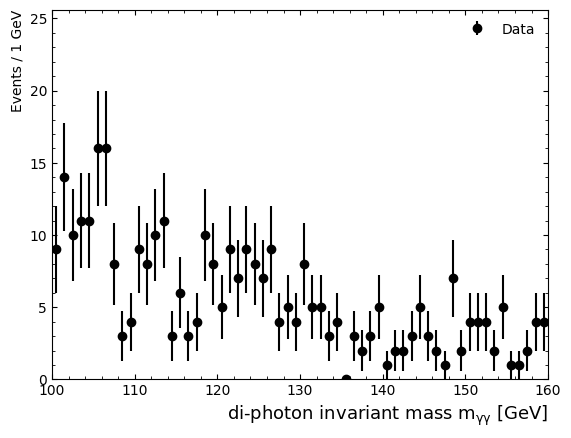

In [26]:
# x-axis range of the plot
xmin = 100 #GeV
xmax = 160 #GeV

# Histogram bin setup
step_size = 1 #GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(data15_periodD), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data


# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes.legend( frameon=False ); # no box around the legend

## Applying data cuts and calculations across all other data collection periods

In [43]:
# Controls the fraction of all the events analysed
fraction = 1 # all of the data is used to run this analysis (implemented in the loop over the tree)
             # reduce this if you want the code to run quicker

all_data = []
sample_data = []

# # Loop over each file
# for val in samples_list['Data']['list']: 

#     # Print which sample is being processed
#     print('Processing '+val+' samples')

#     fileString = val# file name to open

#     # Open file
#     if local_files:
#         # Download the file, use a local copy
#         local_filename = fileString.split("/")[-1]
#         print(f"Downloading {fileString} to {local_filename} ...")
#         with requests.get(fileString, stream=True) as r:
#             r.raise_for_status()
#             with open(local_filename, "wb") as f:
#                 for chunk in r.iter_content(chunk_size=8192):
#                     f.write(chunk)
#         tree = uproot.open(local_filename + ":analysis")
#     else: # Stream files
#         tree = uproot.open(fileString + ":analysis")

#     numevents = tree.num_entries


for val in samples_list['Data']['list']:
    print('Processing ' + val + ' samples')
    fileString = val  # file name to open

    if local_files:
        local_filename = fileString.split("/")[-1]
        if os.path.exists(local_filename):
            print(f"Using existing file {local_filename} ...")
        else:
            print(f"Downloading {fileString} to {local_filename} ...")
            with requests.get(fileString, stream=True) as r:
                r.raise_for_status()
                with open(local_filename, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
        tree = uproot.open(local_filename + ":analysis")
    else:
        tree = uproot.open(fileString + ":analysis")

    numevents = tree.num_entries

    # Perform the cuts for each data entry in the tree and calculate the invariant mass
    for data in tree.iterate(variables, library="ak", entry_stop=numevents*fraction):

        photon_isTightID = data['photon_isTightID']
        data = data[~cut_photon_reconstruction(photon_isTightID)]
        
        photon_pt = data['photon_pt']
        data = data[~cut_photon_pt(photon_pt)]

        data = data[~cut_isolation_pt(data['photon_ptcone20'],data['photon_pt'])]

        photon_eta = data['photon_eta']
        data = data[~cut_photon_eta_transition(photon_eta)]
        
        data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])

        data = data[~cut_mass(data['mass'])]

        data = data[~cut_iso_mass(data['photon_pt'], data['mass'])]
        
        # Append data to the whole sample data list
        sample_data.append(data['mass'])
        
# turns sample_data back into an awkward array
all_data = ak.concatenate(sample_data)

Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodD.GamGam.root samples
Using existing file ODEO_FEB2025_v0_GamGam_data15_periodD.GamGam.root ...
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodE.GamGam.root samples
Using existing file ODEO_FEB2025_v0_GamGam_data15_periodE.GamGam.root ...
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodF.GamGam.root samples
Using existing file ODEO_FEB2025_v0_GamGam_data15_periodF.GamGam.root ...
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodG.GamGam.root samples
Using existing file ODEO_FEB2025_v0_GamGam_data15_periodG.GamGam.root ...
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodH.GamGam.root samples
Using existing file ODEO_FEB2025_v0_GamGam_data15_periodH.GamGam

A 4th order polynomial function represents the background, and a Gaussian function represents the signal. 
The Gaussian model is used due to the nature of the detector's resolution. 
The fourth-order polynomial is chosen for the background because it offers enough flexibility to capture the overall shape without overfitting, thereby reducing the influence of spurious data—random, irrelevant fluctuations or noise that do not correspond to the true signal or background.

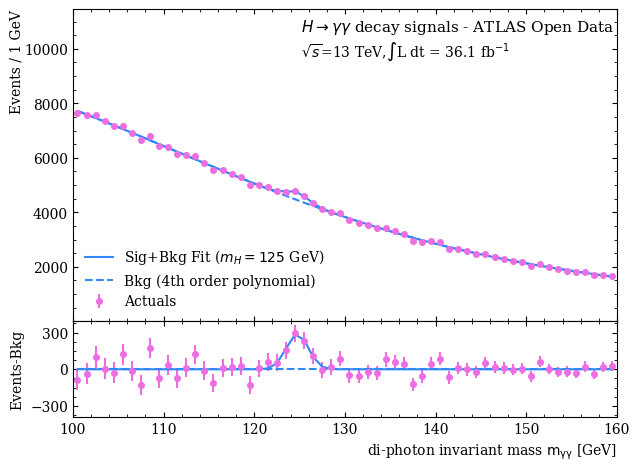

In [44]:
plt.rcParams['font.family'] = 'serif'

data_x,_ = np.histogram(ak.to_numpy(all_data), 
                            bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# data fit
polynomial_mod = PolynomialModel( 4 ) # 4th order polynomial
gaussian_mod = GaussianModel() # Gaussian

# set initial guesses for the parameters of the polynomial model
# c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                            x=bin_centres, c0=data_x.max(), c1=0,
                            c2=0, c3=0, c4=0 )

# set initial guesses for the parameters of the Gaussian model
pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                        x=bin_centres, amplitude=100, 
                        center=125, sigma=2 )

model = polynomial_mod + gaussian_mod # combined model

# fit the model to the data
out = model.fit(data_x, # data to be fit
                pars, # guesses for the parameters
                x=bin_centres, weights=1/data_x_errors ) #ASK

# background part of fit
params_dict = out.params.valuesdict() # get the parameters from the fit to data
c0 = params_dict['c0'] # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c1 = params_dict['c1'] # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c2 = params_dict['c2'] # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c3 = params_dict['c3'] # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c4 = params_dict['c4'] # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4

# get the background only part of the fit to data
background = c0 + c1*bin_centres + c2*bin_centres**2 + c3*bin_centres**3 + c4*bin_centres**4

# data fit - background fit = signal fit
signal_x = data_x - background 


#==== MAIN PLOT ====#

plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                fmt='o', label='Actuals', markersize=4, color = "#ed6de2" ) 

# plot the signal + background fit
main_axes.plot(bin_centres, # x
            out.best_fit, # y
            '#2f88f5', # single line
            label='Sig+Bkg Fit ($m_H=125$ GeV)' )

# plot the background only fit
main_axes.plot(bin_centres, # x
            background, # y
            '#2f88f5',
            linestyle = '--',# dashed line
            label='Bkg (4th order polynomial)' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x-axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                    direction='in', # Put ticks inside and outside the axes
                    top=True, # draw ticks on the top axis
                    labelbottom=False, # don't draw tick labels on bottom axis
                    right=True ) # draw ticks on right axis

# write y-axis label for main 
main_axes.set_ylabel('Events / '+str(step_size)+' GeV', 
                    horizontalalignment='right') 

# set the y-axis limit for the main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5 ) 

# set minor ticks on the y-axis of the main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# avoid displaying y=0 on the main axes
main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

# Add text 'ATLAS Open Data' on plot
plt.text(0.42, # x
        0.93, # y
        r'$H \rightarrow \gamma\gamma$ decay signals - ATLAS Open Data', # text
        transform=main_axes.transAxes, # coordinate system used is that of main_axes
        fontsize=11 ) 

lumi = 36.1
lumi_used = str(lumi*fraction) # luminosity to write on the plot
plt.text(0.42, # x
        0.85, # y
        '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
        transform=main_axes.transAxes, fontsize=10 ) # coordinate system used is that of main_axes 

# draw the legend
main_axes.legend(frameon=False, # no box around the legend
                loc='lower left' ) # legend location 



# ==== Data-Bkg Residuals plot ==== # 

plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
sub_axes = plt.gca() # get the current axes

# set the y axis to be symmetric about Data-Background=0
sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                            symmetric=True) )

# plot Data-Background
sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,
                fmt='o',markersize=4, color = '#ed6de2')

# draw the fit to data
sub_axes.plot(bin_centres, # x
            out.best_fit-background, # y
            '#2f88f5' ) # single line

# draw the background only fit
sub_axes.plot(bin_centres, # x
            background-background, # y
            '#2f88f5',
             linestyle = '--')  # dashed red line

# set the x-axis limits on the sub axes
sub_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x-axis minor ticks
sub_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# x-axis label
sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                    x=1, horizontalalignment='right', 
                    fontsize=10 ) 

# set the tick parameters for the sub axes
sub_axes.tick_params(which='both', # ticks on both x and y axes
                    direction='in', # Put ticks inside and outside the axes
                    top=True, # draw ticks on the top axis
                    right=True ) # draw ticks on right axis 

# separation of y-axis minor ticks
sub_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# y-axis label on the sub axes
sub_axes.set_ylabel( 'Events-Bkg' ) 


# Generic features for both plots
main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
sub_axes.yaxis.set_label_coords( -0.09, 0.5 )

This chart displays the results of a measurement of the Higgs boson decaying into two photons.
using data collected by the ATLAS experiment at the Large Hadron Collider (LHC). The data corresponds to proton-proton collisions at a center-of-mass energy of 13 TeV, with a total integrated luminosity of 36.1 fb
X-axis: Shows the invariant mass of the photon pairs, measured in GeV. If these two photons originate from the decay of a single particle (like the Higgs boson), their invariant mass will cluster around the mass of that particle.

Y-axis: The number of events per GeV (event rate) for each bin of diphoton invariant mass.

Data Points (pink dots): The actual measured data from the ATLAS detector, showing how many diphoton events were observed at each invariant mass.

Background Fit (blue dashed line): The expected number of diphoton events from all Standard Model processes except the Higgs boson. This background is mostly due to other processes that produce two photons but not from Higgs decay.

Signal + Background Fit (blue line): The sum of the background and the expected Higgs boson signal, as predicted by the Standard Model and fit to the data.

The narrow bump at c.125 GeV is a signature of the Higgs boson decaying into two photons. The Standard Model predicts the Higgs boson mass to be about 125 GeV, and this is where the excess is observed.
